<a href="https://colab.research.google.com/github/VMink/Multiagentes/blob/main/ProyectoMultiagentes_SemaforoInteligente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mesa

# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes.
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model

# Debido a que necesitamos un solo agente por celda elegimos `SingleGrid` que fuerza un solo objeto por celda.
from mesa.space import SingleGrid, MultiGrid

# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation, RandomActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos
# para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Steps taken by all agents: 199
Simulation over in 25.00 seconds


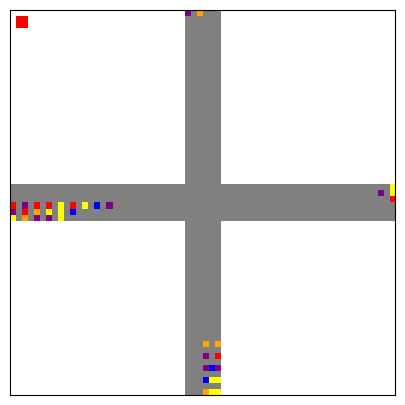

In [2]:
#Parameters for simulation
GRID_LENGTH = 64
GRID_HEIGHT = 64
FRAMERATE = 8
TIME_LIMIT = 25
NO_CARS = 40

class controllAgent(Agent):
  def __init__(self,unique_id,model):
    super().__init__(unique_id, model)
    # Este atributo guarda el objeto semaforo que este activo en ese momento
    self.light_act = None
    # Esta variable sirve como un time cuando un semaforo cambia de verde a rojo, dandole tiempo a los carros de pasar antes poner otro semaforo en verde
    self.timer = 5
    # Este booleano sirve como un auxiliar para activar el timer, este nos indica si se pondrá en verde un semaforo nuevo
    self.cambio = False

  def step(self):
    # Si no está activo cambio(o sea no esta cambiando de semaforo), entrará a evaluar cual semaforo debe estár en verde
    if not self.cambio:
      max = -1
      new_sem = None
      # Recorre todos los semaforos y evalua la cantidad de carros que tiene
      for semaforo in self.model.light:
        if semaforo.car_count > max:
          max = semaforo.car_count
          new_sem = semaforo
      # Si el atributo light_act es None significa que aun no hay ningun semaforo activo, por lo que no se activará el booleano cambio
      if self.light_act is None:
        self.light_act = new_sem
        self.light_act.color = 1
      # En caso de que ya haya un semaforo activo se evalua si el nuevo semaforo es el mismo o se hará un cambio
      else:
        if new_sem != self.light_act:
          self.light_act.color = 2
          self.light_act = new_sem
          self.cambio = True
    # En caso de que cambio sea True se realizarán 5 steps vacios para que los carros puedan pasar
    else:
      if self.timer == 5:
        self.light_act.color = 1
        self.cambio = False
        self.timer = 0
      else:
        self.timer += 1

#Light agents
class lightAgent(Agent):
    def __init__(self, unique_id, model, orientacion, inicio, fin, xy_ini, xy_fin):
        super().__init__(unique_id, model)
        # Este atributo controla si el semaforo está en verde o rojo
        self.color=2
        # Este lleva la cuenta de cuantos carros hay en el carril de este semaforo
        self.car_count = 0
        # Estos atributos guardan las coordenadas de inicio y fin en X y Y del area del semaforo, o sea los 3 carriles del semaforo
        self.inicio = inicio
        self.fin = fin
        self.dire = orientacion
        self.posi_ini = xy_ini
        self.posi_fin = xy_fin

    def step(self):
      # Se iguala el contador de carros a 0 para que se actualice en cada step
      self.car_count = 0
      # Este if solo evalua si el carril es vertical u horizontal
      if(self.dire == True):
        # Se recorre cada coordenada el carril del semaforo y se cuenta la cantidad de carros
        for i in range(self.posi_ini, self.posi_fin +1):
          for j in range(self.inicio, self.fin+1):
            cell_agentes = model.grid.get_cell_list_contents((j, i))
            self.car_count += len(cell_agentes)
      else:
        for i in range(self.posi_ini, self.posi_fin +1):
          for j in range(self.inicio, self.fin+1):
            cell_agentes = model.grid.get_cell_list_contents((i, j))
            self.car_count += len(cell_agentes)


#Car agent
class carAgent(Agent):
    def __init__(self, unique_id, model, type, big_lane, startingPosition, targetPosition, lane):
        super().__init__(unique_id, model)
        self.type=type
        self.startingPosition = startingPosition  # 1 to 4: left, top, right, bottom
        self.targetPosition = targetPosition  # (X, Y) coordinate
        self.lane = lane
        self.big_lane = big_lane
        self.direccion = None

    # Step function
    def step(self):
        currentX, currentY = self.pos
        targetX, targetY = self.targetPosition

        if (currentX,currentY) == (0,0):
            return

        if self.big_lane == 1:
            light = self.model.grid.get_cell_list_contents((1,1))[0]
            if ((self.lane == 1 or self.lane == 2) and light.color == 1) or currentX >= 29 or currentX < 28:
                if currentX < targetX:
                    if currentX < 28:
                      cell_agentes = model.grid.get_cell_list_contents((currentX + 2, currentY))
                      if len(cell_agentes) == 0:
                        self.model.grid.move_agent(self, (currentX + 1, currentY))
                        self.direccion = "derecha"
                    else:
                      self.model.grid.move_agent(self, (currentX + 1, currentY))
                      self.direccion = "derecha"
                else:
                    if currentY > targetY:
                      self.model.grid.move_agent(self, (currentX, currentY - 1))
                      self.direccion = "arriba"

            if self.lane == 3:
                if currentX < targetX:
                    self.model.grid.move_agent(self, (currentX + 1, currentY))
                    self.direccion = "derecha"
                else:
                    if currentY < targetY:
                        self.model.grid.move_agent(self, (currentX, currentY + 1))
                        self.direccion = "abajo"

        if self.big_lane == 3:
            light = self.model.grid.get_cell_list_contents((1,2))[0]
            if ((self.lane == 1 or self.lane == 2) and light.color == 1) or currentX <= 34 or currentX > 35:
                if currentX > targetX:
                  if currentX > 35:
                    cell_agentes = model.grid.get_cell_list_contents((currentX - 2, currentY))
                    if len(cell_agentes) == 0:
                      self.model.grid.move_agent(self, (currentX - 1, currentY))
                      self.direccion = "izquierda"
                  else:
                    self.model.grid.move_agent(self, (currentX - 1, currentY))
                    self.direccion = "izquierda"
                else:
                    if currentY < targetY:
                          self.model.grid.move_agent(self, (currentX, currentY + 1))
                          self.direccion = "abajo"

            if self.lane == 3:
                if currentX > targetX:
                    self.model.grid.move_agent(self, (currentX - 1, currentY))
                    self.direccion = "izquierda"
                else:
                    if currentY > targetY:
                        self.model.grid.move_agent(self, (currentX, currentY - 1))
                        self.direccion = "arriba"

        if self.big_lane == 2:
            light = self.model.grid.get_cell_list_contents((2,1))[0]
            if ((self.lane == 1 or self.lane == 2) and light.color == 1) or currentY <= 34 or currentY > 35:
                if currentY > targetY:
                  if currentY > 35:
                    cell_agentes = model.grid.get_cell_list_contents((currentX, currentY - 2))
                    if len(cell_agentes) == 0:
                      self.model.grid.move_agent(self, (currentX, currentY - 1))
                      self.direccion = "abajo"
                  else:
                    self.model.grid.move_agent(self, (currentX, currentY - 1))
                    self.direccion = "abajo"
                else:
                    if currentX > targetX:
                          self.model.grid.move_agent(self, (currentX - 1, currentY))
                          self.direccion = "derecha"

            if self.lane == 3:
                if currentY > targetY:
                    self.model.grid.move_agent(self, (currentX, currentY - 1))
                else:
                    if currentX < targetX:
                        self.model.grid.move_agent(self, (currentX + 1, currentY))

        if self.big_lane == 4:
            light = self.model.grid.get_cell_list_contents((2,2))[0]
            if ((self.lane == 1 or self.lane == 2) and light.color == 1) or currentY >= 29 or currentY < 28:
                if currentY < targetY:
                  if currentY < 28:
                    cell_agentes = model.grid.get_cell_list_contents((currentX, currentY + 2))
                    if len(cell_agentes) == 0:
                      self.model.grid.move_agent(self, (currentX, currentY + 1))
                  else:
                    self.model.grid.move_agent(self, (currentX, currentY + 1))
                else:
                    if currentX < targetX:
                        self.model.grid.move_agent(self, (currentX + 1, currentY))

            if self.lane == 3:
                if currentY < targetY:
                    self.model.grid.move_agent(self, (currentX, currentY + 1))
                else:
                    if currentX > targetX:
                        self.model.grid.move_agent(self, (currentX - 1, currentY))

        if (currentX, currentY) == self.targetPosition:
            self.model.grid.move_agent(self, (0,0))

#Get grid for visualization
def get_grid(model):
    grid = np.full((model.grid.width, model.grid.height, 3), (255, 255, 255), dtype=np.uint8)

    #Street Coloring
    for x in range(29, 35):
        for y in range(0, 64):
            grid[x][y] = (128, 128, 128)  # Gray color
    for x in range(0, 64):
        for y in range(29, 35):
            grid[x][y] = (128, 128, 128)  # Gray color


    for cell in model.grid.coord_iter():
        cell_agents, pos = cell
        if cell_agents:
            #List all agents to visualize
            allCarAgents = [agent for agent in cell_agents if isinstance(agent, carAgent)]
            allLightAgents = [agent for agent in cell_agents if isinstance(agent, lightAgent)]

            if allCarAgents:
                # Assign colors based on each car agent's type attribute
                for agent in allCarAgents:
                    carType = agent.type
                    color = get_color_for_car_type(carType)
                    grid[pos[1]][pos[0]] = color
                    if color is not None:
                        grid[pos[1]][pos[0]] = color
            if allLightAgents:
                # Assign colors based on each light agent's color attribute
                for agent in allLightAgents:
                    lightColor = agent.color
                    color = get_color_for_light_color(lightColor)
                    if color is not None:
                        grid[pos[1]][pos[0]] = color
        (128,126,120)

    return grid

def get_color_for_light_color(lightColor):
    light_color_mapping = {
        1: (0, 255, 0),    # Green
        2: (255, 0, 0),    # Red
    }
    return light_color_mapping[lightColor]

def get_color_for_car_type(carType):
    color_mapping = {
        0: (0, 0, 0),        # Black
        1: (255, 0, 0),      # Red
        2: (0, 0, 255),      # Blue
        3: (255, 255, 0),    # Yellow
        4: (128, 0, 128),    # Purple
        5: (255, 165, 0)     # Orange
    }
    # Return the color type (or black if it's not defined)
    return color_mapping.get(carType, (0, 0, 0))

#trafficModel
class trafficModel(Model):
    def __init__(self, length, height):
        self.grid = MultiGrid(length, height, torus=True)
        self.schedule = SimultaneousActivation(self)
        self.no_cars = NO_CARS
        self.light = []

        #Place light Agents
        a = lightAgent(1, self, True, 0, 28, 32, 34)
        self.grid.place_agent(a, (1, 1))
        self.schedule.add(a)
        b = lightAgent(2, self, False, 35, 63, 32, 34)
        self.grid.place_agent(b, (2, 1))
        self.schedule.add(b)
        c = lightAgent(3, self, True, 35, 63, 29, 31)
        self.grid.place_agent(c, (1, 2))
        self.schedule.add(c)
        d = lightAgent(4, self, False, 0, 28, 29, 31)
        self.grid.place_agent(d, (2, 2))
        self.schedule.add(d)

        self.light.append(a)
        self.light.append(b)
        self.light.append(c)
        self.light.append(d)

        controller = controllAgent(5, self)
        self.schedule.add(controller)

        lane = 1
        id = 100
        while lane <= 4:
            if self.no_cars > 0:
                randomized_cars = np.random.randint(0,self.no_cars)
                self.no_cars = self.no_cars-randomized_cars
                if lane == 1:
                    x_lane1 = 0
                    x_lane2 = 0
                    x_lane3 = 0
                    for x in  range(randomized_cars):
                        randomized_inner_lane = np.random.randint(1,4)
                        if randomized_inner_lane == 1:
                            a = carAgent(id, self, np.random.randint(1,6), 1, (x_lane1, 32), (32,0), randomized_inner_lane)
                            self.grid.place_agent(a, (x_lane1, 32))
                            self.schedule.add(a)
                            x_lane1 += 2
                            id += 1
                        elif randomized_inner_lane == 2:
                            a = carAgent(id, self, np.random.randint(1,6), 1, (x_lane2, 33), (63,33), randomized_inner_lane)
                            self.grid.place_agent(a, (x_lane2, 33))
                            self.schedule.add(a)
                            x_lane2 += 2
                            id += 1
                        elif randomized_inner_lane == 3:
                            a = carAgent(id, self, np.random.randint(1,6), 1, (x_lane3, 34), (29,63), randomized_inner_lane)
                            self.grid.place_agent(a, (x_lane3, 34))
                            self.schedule.add(a)
                            x_lane3 += 2
                            id += 1
                elif lane == 2:
                    y_lane1 = 63
                    y_lane2 = 63
                    y_lane3 = 63
                    for x in  range(randomized_cars):
                        randomized_inner_lane = np.random.randint(1,4)
                        if randomized_inner_lane == 1:
                            a = carAgent(id, self, np.random.randint(1,6), 2, (32, y_lane1), (0,31), randomized_inner_lane)
                            self.grid.place_agent(a, (32, y_lane1))
                            self.schedule.add(a)
                            y_lane1 -= 2
                            id += 1
                        elif randomized_inner_lane == 2:
                            a = carAgent(id, self, np.random.randint(1,6), 2, (33, y_lane2), (33,0), randomized_inner_lane)
                            self.grid.place_agent(a, (33, y_lane2))
                            self.schedule.add(a)
                            y_lane2 -= 2
                            id += 1
                        elif randomized_inner_lane == 3:
                            a = carAgent(id, self, np.random.randint(1,6), 2, (34, y_lane3), (63,34), randomized_inner_lane)
                            self.grid.place_agent(a, (34, y_lane3))
                            self.schedule.add(a)
                            y_lane3 -= 2
                            id += 1
                elif lane == 3:
                    x_lane1 = 63
                    x_lane2 = 63
                    x_lane3 = 63
                    for x in  range(randomized_cars):
                        randomized_inner_lane = np.random.randint(1,4)
                        if randomized_inner_lane == 1:
                            a = carAgent(id, self, np.random.randint(1,6), 3, (x_lane1, 31), (31, 63), randomized_inner_lane)
                            self.grid.place_agent(a, (x_lane1, 31))
                            self.schedule.add(a)
                            x_lane1 -= 2
                            id += 1
                        elif randomized_inner_lane == 2:
                            a = carAgent(id, self, np.random.randint(1,6), 3, (x_lane2, 30), (0, 30), randomized_inner_lane)
                            self.grid.place_agent(a, (x_lane2, 30))
                            self.schedule.add(a)
                            x_lane2 -= 2
                            id += 1
                        elif randomized_inner_lane == 3:
                            a = carAgent(id, self, np.random.randint(1,6), 3, (x_lane3, 29), (34, 0), randomized_inner_lane)
                            self.grid.place_agent(a, (x_lane3, 29))
                            self.schedule.add(a)
                            x_lane3 -= 2
                            id += 1
                elif lane == 4:
                    y_lane1 = 0
                    y_lane2 = 0
                    y_lane3 = 0
                    for x in  range(randomized_cars):
                        randomized_inner_lane = np.random.randint(1,4)
                        if randomized_inner_lane == 1:
                            a = carAgent(id, self, np.random.randint(1,6), 4, (31, y_lane1), (63, 32), randomized_inner_lane)
                            self.grid.place_agent(a, (31, y_lane1))
                            self.schedule.add(a)
                            y_lane1 += 2
                            id += 1
                        elif randomized_inner_lane == 2:
                            a = carAgent(id, self, np.random.randint(1,6), 4, (30, y_lane2), (30, 63), randomized_inner_lane)
                            self.grid.place_agent(a, (30, y_lane2))
                            self.schedule.add(a)
                            y_lane2 += 2
                            id += 1
                        elif randomized_inner_lane == 3:
                            a = carAgent(id, self, np.random.randint(1,6), 4, (29, y_lane3), (0, 29), randomized_inner_lane)
                            self.grid.place_agent(a, (29, y_lane3))
                            self.schedule.add(a)
                            y_lane3 += 2
                            id += 1
                lane += 1


        # Start data collector
        self.datacollector = DataCollector(
            model_reporters={"Grid": get_grid})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

#Calculate the max number of steps
numSteps = FRAMERATE * TIME_LIMIT
model = trafficModel(GRID_LENGTH, GRID_HEIGHT)


#Start model
for i in range(numSteps):
    model.step()
    agentSteps=i
print(f"Steps taken by all agents: {agentSteps:.0f}")
elapsedTime = (i+1) / FRAMERATE
print(f"Simulation over in {elapsedTime:.2f} seconds")

#Collect data
all_grid = model.datacollector.get_model_vars_dataframe()

#Plot the data
fig, axs = plt.subplots(figsize=(10, 5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0])

def animate(i):
    model.step()  # Make sure to update the model state
    patch.set_data(all_grid.iloc[i][0])

#Variable to assign the animation framerate
calculatedInterval = 1000 / FRAMERATE
anim = animation.FuncAnimation(fig, animate, frames=len(all_grid), interval=calculatedInterval)

In [3]:
anim